This implementation now includes:

1) Activation Functions: Sigmoid, ReLU, and Tanh with their derivatives.
2) Loss Functions: Mean Squared Error and Cross-Entropy with their derivatives.
3) Regularization: L1 and L2 regularization with their derivatives.
4) Optimizers: SGD, Adam, and AdaMax.
6) Callbacks: EarlyStopping for stopping training when the loss doesn't improve.
7) History: Tracking and printing the loss at the end of each epoch.
8) Evaluation metrics : Evaluating model against several parameters like Accuracy, Mean Square Error, Log Loss, Precision.

The train method accepts callbacks to integrate these features, and the optimizer is used to update weights and biases during training.

In [6]:
import numpy as np

'''
ActivationFunction: 
This class provides static methods for commonly used activation functions in neural networks, along with their derivatives. 
These functions introduce non-linearity into the network, allowing it to learn complex relationships in the data.
'''

class ActivationFunction:
    # sigmoid: Applies the sigmoid function (squashes values between 0 and 1).
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # sigmoid_derivative: Calculates the derivative of the sigmoid function.
    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)
    
    # relu: Applies the rectified linear unit (ReLU) function (outputs the input directly if positive, otherwise 0).
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    # relu_derivative: Calculates the derivative of the ReLU function.
    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)
    
    # tanh: Applies the hyperbolic tangent function (squashes values between -1 and 1).
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    # tanh_derivative: Calculates the derivative of the hyperbolic tangent function.
    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x) ** 2

'''
LossFunction: 
This class provides static methods for calculating loss functions, which measure how well the network's predictions match the actual targets.
'''

class LossFunction:
    # mean_squared_error: Calculates the mean squared error between predicted and true values.
    @staticmethod
    def mean_squared_error(y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    # mean_squared_error_derivative: Calculates the derivative of the mean squared error.
    @staticmethod
    def mean_squared_error_derivative(y_true, y_pred):
        return 2 * (y_pred - y_true) / y_true.size
    
    # cross_entropy: Calculates the cross-entropy loss (commonly used for classification problems).
    @staticmethod
    def cross_entropy(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    # cross_entropy_derivative: Calculates the derivative of the cross-entropy loss.
    @staticmethod
    def cross_entropy_derivative(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return (y_pred - y_true) / (y_pred * (1 - y_pred))
    
    # log_loss: Calculates the log loss between predicted and true values.
    @staticmethod
    def log_loss(y_true, y_pred):
        return -np.mean(y_true * np.log(np.clip(y_pred, 1e-15, 1 - 1e-15)) + (1 - y_true) * np.log(1 - np.clip(y_pred, 1e-15, 1 - 1e-15)))

'''
Regularization: 
This class provides static methods for regularization techniques, which help prevent overfitting by penalizing large weights.
'''

class Regularization:
    # l1: Calculates the L1 norm of the weights (sum of absolute values).
    @staticmethod
    def l1(weights, alpha):
        return alpha * np.sum(np.abs(weights))
    
    # l1_derivative: Calculates the derivative of the L1 norm.
    @staticmethod
    def l1_derivative(weights, alpha):
        return alpha * np.sign(weights)
    
    # l2: Calculates the L2 norm of the weights (sum of squares).
    @staticmethod
    def l2(weights, alpha):
        return alpha / 2 * np.sum(np.square(weights))
    
    # l2_derivative: Calculates the derivative of the L2 norm.
    @staticmethod
    def l2_derivative(weights, alpha):
        return alpha * weights

'''
Optimizer: 
This is an abstract class that defines the interface for updating the network's weights during training. 
Subclasses implement specific optimization algorithms.
'''
class Optimizer:
    # update: This method is not implemented in the abstract class but should be defined by subclasses to update weights based on gradients and learning rate.
    def update(self, weights, gradients, learning_rate):
        raise NotImplementedError

'''
SGD (Stochastic Gradient Descent):
This class implements the SGD optimizer, which updates weights based on the gradients of a single data point at a time.
'''
class SGD(Optimizer):
    # update: Updates weights by subtracting the learning rate times the gradients.
    def update(self, weights, gradients, learning_rate):
        return weights - learning_rate * gradients

'''
Adam (Adaptive Moment Estimation):
This class implements the Adam optimizer, a more advanced algorithm that adapts the learning rate for each weight based on past gradients.
'''
class Adam(Optimizer):
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    # update: Updates weights using the Adam algorithm with momentum and adaptive learning rates.
    def update(self, weights, gradients, learning_rate, layer_id):
        if layer_id not in self.m:
            self.m[layer_id] = np.zeros_like(weights)
            self.v[layer_id] = np.zeros_like(weights)
        
        self.t += 1
        self.m[layer_id] = self.beta1 * self.m[layer_id] + (1 - self.beta1) * gradients
        self.v[layer_id] = self.beta2 * self.v[layer_id] + (1 - self.beta2) * np.square(gradients)

        m_hat = self.m[layer_id] / (1 - self.beta1 ** self.t)
        v_hat = self.v[layer_id] / (1 - self.beta2 ** self.t)

        return weights - learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

'''
EarlyStopping: 
This class implements a callback for early stopping during training. 
It monitors the validation loss and stops training if the loss doesn't improve for a certain number of epochs (iterations).
'''
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.wait = 0
        self.stopped_epoch = 0

    # __call__: Checks if the validation loss has stopped improving and returns True for early stopping.
    def __call__(self, current_loss, epoch):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True
        return False

'''
History:
This class keeps track of the loss values during training for monitoring and visualization purposes.
'''
class History:
    def __init__(self):
        self.losses = []

    # on_epoch_end: Appends the loss value for the current epoch to the internal list.
    def on_epoch_end(self, epoch, loss):
        self.losses.append(loss)
        print(f'Epoch {epoch + 1}: loss = {loss}')

'''
NeuralNetwork: 
This is the main class that builds trains and evaluates the neural network.
'''
class NeuralNetwork:
    # __init__: Initializes the network with empty layers, loss function, optimizer, etc.
    def __init__(self):
        self.layers = []
        self.loss_function = None
        self.loss_derivative = None
        self.regularization = None
        self.regularization_param = 0
        self.optimizer = None

    # add_layer: Adds a new layer to the network with a specified number of inputs, neurons, and activation function.
    def add_layer(self, num_inputs, num_neurons, activation_function='sigmoid'):
        layer = {
            'weights': np.random.randn(num_inputs, num_neurons) * 0.1,
            'biases': np.zeros((1, num_neurons)),
            'activation_function': getattr(ActivationFunction, activation_function),
            'activation_derivative': getattr(ActivationFunction, activation_function + '_derivative')
        }
        self.layers.append(layer)

    # set_loss_function: Sets the loss function used for calculating the error between predictions and targets.
    def set_loss_function(self, loss_function):
        self.loss_function = getattr(LossFunction, loss_function)
        self.loss_derivative = getattr(LossFunction, loss_function + '_derivative')

    # set_regularization: Sets the regularization technique and its parameter (alpha) used to prevent overfitting.
    def set_regularization(self, regularization, alpha):
        self.regularization = getattr(Regularization, regularization)
        self.regularization_derivative = getattr(Regularization, regularization + '_derivative')
        self.regularization_param = alpha

    # set_optimizer: Sets the optimizer algorithm used for updating the network's weights during training.
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    # forward_propagation: Propagates the input data through the network's layers, applying activation functions at each step.
    def forward_propagation(self, X):
        for layer in self.layers:
            Z = np.dot(X, layer['weights']) + layer['biases']
            A = layer['activation_function'](Z)
            layer['Z'] = Z
            layer['A'] = A
            X = A
        return X
    
    # backward_propagation: Calculates the gradients of the loss function with respect to the weights and biases, used for updating them during training.
    def backward_propagation(self, X, y, learning_rate):
        m = y.size
        dA = self.loss_derivative(y, self.layers[-1]['A'])
        
        for i in reversed(range(len(self.layers))):
            dZ = dA * self.layers[i]['activation_derivative'](self.layers[i]['A'])
            dW = np.dot(self.layers[i-1]['A'].T, dZ) if i > 0 else np.dot(X.T, dZ)
            dB = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, self.layers[i]['weights'].T)
            
            if self.regularization:
                dW += self.regularization_derivative(self.layers[i]['weights'], self.regularization_param)
            
            if self.optimizer:
                self.layers[i]['weights'] = self.optimizer.update(self.layers[i]['weights'], dW, learning_rate, f'layer_{i}_weights')
                self.layers[i]['biases'] = self.optimizer.update(self.layers[i]['biases'], dB, learning_rate, f'layer_{i}_biases')
            else:
                self.layers[i]['weights'] -= learning_rate * dW
                self.layers[i]['biases'] -= learning_rate * dB
    
    # calculate_loss: Calculates the loss value based on the chosen loss function and any regularization penalty.
    def calculate_loss(self, y_true, y_pred):
        loss = self.loss_function(y_true, y_pred)
        if self.regularization:
            for layer in self.layers:
                loss += self.regularization(layer['weights'], self.regularization_param)
        return loss
    
    # train: Trains the network on a given dataset for a specified number of epochs (iterations) using the chosen optimizer and learning rate. 
    # It also supports callbacks for monitoring the training process.
    def train(self, X, y, epochs, learning_rate, callbacks=[]):
        history = History()
        for epoch in range(epochs):
            y_pred = self.forward_propagation(X)
            loss = self.calculate_loss(y, y_pred)
            self.backward_propagation(X, y, learning_rate)
            history.on_epoch_end(epoch, loss)
            for callback in callbacks:
                if callback(loss, epoch):
                    print(f'Early stopping at epoch {epoch + 1}')
                    return history
        return history
    
    # predict: Uses the trained network to make predictions on a new set of input data.
    def predict(self, X):
        return self.forward_propagation(X)
    
    # evaluation_metrics: Calculate various model evaluation metrics which include error calculations as well.
    def evaluation_metrics(self,target_list,prediction_list):
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0
        for l1,l2 in zip(target_list, prediction_list):
            if (l1 == 1 and  np.round(l2) == 1):
                true_positive = true_positive + 1
            elif (l1 == 0 and np.round(l2) == 0):
                true_negative = true_negative + 1
            elif (l1 == 1 and np.round(l2) == 0):
                false_negative = false_negative + 1
            elif (l1 == 0 and np.round(l2) == 1):
                false_positive = false_positive + 1
        result={}

        binary_predictions = np.round(prediction_list)
        correct_predictions = np.sum(binary_predictions == target_list)
        total_predictions = len(target_list)
        
        result["Accuracy"] = correct_predictions / total_predictions
        result["Mean Square Error"] = np.mean(np.square(target_list - predictions))
        result["Mean Absolute Error"] = np.mean(np.abs(target_list - prediction_list))
        LL = -np.mean(target_list * np.log(np.clip(prediction_list, 1e-15, 1 - 1e-15)) + (1 - target_list) * np.log(1 - np.clip(prediction_list, 1e-15, 1 - 1e-15)))
        result["Log Loss"] = LL
        
        result["True Positives"] = true_positive
        result["True Negatives"] = true_negative
        result["False Positives"] = false_positive
        result["False Negatives"] = false_negative

        precision=0
        recall=0
        if(true_positive + false_positive)!=0:
            precision = true_positive/(true_positive + false_positive)
            recall = true_positive/(true_positive + false_negative)
        result["Precision"] = precision
        result["Recall"] = recall
        result["Specificity"] = 0
        if (true_negative + false_positive)!=0:
            result["Specificity"] = true_negative/(true_negative + false_positive)
        result["Negative Predictive Value"] = 0
        if (true_negative + false_negative)!=0:
            result["Negative Predictive Value"] = true_negative/(true_negative + false_negative)
        result["F-Measure"] = 0
        if (precision + recall)!=0:
            result["F-Measure"] = (2* precision * recall)/(precision + recall) #F1 score
        return result

In [7]:
if __name__ == "__main__":
    # Create a Neural Network instance
    nn = NeuralNetwork()

    # Add layers (input layer with 2 inputs, one hidden layer with 3 neurons, output layer with 1 neuron)
    nn.add_layer(num_inputs=2, num_neurons=3, activation_function='relu')
    nn.add_layer(num_inputs=3, num_neurons=1, activation_function='sigmoid')

    # Set the loss function to Mean Squared Error
    nn.set_loss_function('mean_squared_error')

    # Set regularization (L2 with alpha = 0.01)
    nn.set_regularization('l2', alpha=0.01)

    # Set optimizer (Adam)
    nn.set_optimizer(Adam())

    # Training data (XOR problem)
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y = np.array([[0], [1], [1], [0]])

    # Train the neural network without callbacks
    history = nn.train(X, y, epochs=10000, learning_rate=0.1)

    # Train the neural network with EarlyStopping callback
    early_stopping = EarlyStopping(patience=100, min_delta=0.0001)
    history_with_callback = nn.train(X, y, epochs=10000, learning_rate=0.1, callbacks=[early_stopping])

    # Make predictions
    predictions = nn.predict(X)
    print("Predictions:", predictions)
    print("Training Loss History:", history.losses)


Epoch 1: loss = 0.25065033820498606
Epoch 2: loss = 0.2505093203330679
Epoch 3: loss = 0.2502287597445824
Epoch 4: loss = 0.25033584731099284
Epoch 5: loss = 0.25066654570437313
Epoch 6: loss = 0.2505652111916104
Epoch 7: loss = 0.2505597279248461
Epoch 8: loss = 0.2504924759932053
Epoch 9: loss = 0.25022729533390936
Epoch 10: loss = 0.25015113566337516
Epoch 11: loss = 0.2501593321007528
Epoch 12: loss = 0.2500998198468002
Epoch 13: loss = 0.25015312307173937
Epoch 14: loss = 0.2502501981178908
Epoch 15: loss = 0.25021171576072576
Epoch 16: loss = 0.25022919282280603
Epoch 17: loss = 0.2502061649492599
Epoch 18: loss = 0.250119630049926
Epoch 19: loss = 0.2501386946630996
Epoch 20: loss = 0.25006439007870485
Epoch 21: loss = 0.2500736841389146
Epoch 22: loss = 0.25007558420881304
Epoch 23: loss = 0.25008963698019415
Epoch 24: loss = 0.2501235256749263
Epoch 25: loss = 0.25008711187232413
Epoch 26: loss = 0.25008365648703546
Epoch 27: loss = 0.25002417542461103
Epoch 28: loss = 0.25004

Epoch 1: loss = 0.4412517605346129
Epoch 2: loss = 0.44074044916110744
Epoch 3: loss = 0.3943925206492993
Epoch 4: loss = 0.32911523481789823
Epoch 5: loss = 0.24072921974284156
Epoch 6: loss = 0.2549059635364349
Epoch 7: loss = 0.2115009331204293
Epoch 8: loss = 0.1950655784477316
Epoch 9: loss = 0.19504450076298324
Epoch 10: loss = 0.17840420187842668
Epoch 11: loss = 0.17562584603668185
Epoch 12: loss = 0.15616616164560143
Epoch 13: loss = 0.1464965379426758
Epoch 14: loss = 0.13758581542426546
Epoch 15: loss = 0.12447178579058253
Epoch 16: loss = 0.11357290708482545
Epoch 17: loss = 0.10210774157098068
Epoch 18: loss = 0.09102924560344301
Epoch 19: loss = 0.08022184625058064
Epoch 20: loss = 0.0854898394914379
Epoch 21: loss = 0.08795519603429183
Epoch 22: loss = 0.07795944906035501
Epoch 23: loss = 0.06020265972407891
Epoch 24: loss = 0.06036354272627062
Epoch 25: loss = 0.053564361569192635
Epoch 26: loss = 0.05419282533043196
Epoch 27: loss = 0.05123946064506323
Epoch 28: loss =

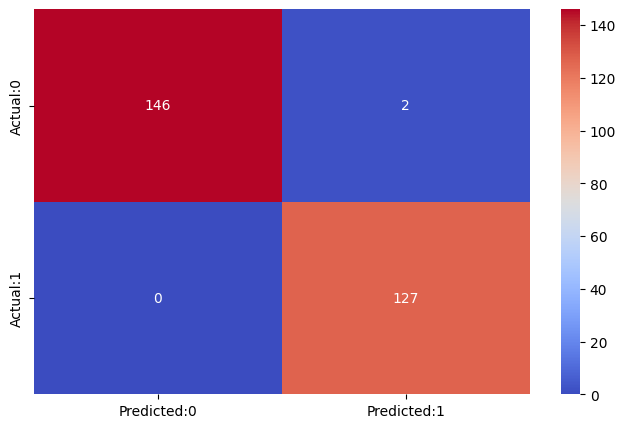

Training Loss History: [0.4412517605346129, 0.44074044916110744, 0.3943925206492993, 0.32911523481789823, 0.24072921974284156, 0.2549059635364349, 0.2115009331204293, 0.1950655784477316, 0.19504450076298324, 0.17840420187842668, 0.17562584603668185, 0.15616616164560143, 0.1464965379426758, 0.13758581542426546, 0.12447178579058253, 0.11357290708482545, 0.10210774157098068, 0.09102924560344301, 0.08022184625058064, 0.0854898394914379, 0.08795519603429183, 0.07795944906035501, 0.06020265972407891, 0.06036354272627062, 0.053564361569192635, 0.05419282533043196, 0.05123946064506323, 0.05285463558325034, 0.05365182792404748, 0.036992370029322555, 0.04699752778577416, 0.05058857836002796, 0.03851122529105059, 0.0521113416028221, 0.03794535987766169, 0.04462280450214569, 0.03532963237896072, 0.03741253301130084, 0.053070907863190096, 0.03947895088663044, 0.03256323712039103, 0.03581216048681686, 0.03699984614717872, 0.035675472567345386, 0.033364178742747545, 0.03744547459166069, 0.03384830208

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from CSV file
data = pd.read_csv('Data/Bank_Data 1.csv')
# Assuming the last column is the target variable
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the input, hidden, and output sizes
input_size = X_train.shape[1]

# Create a Neural Network instance
nn = NeuralNetwork()

# Add layers (input layer with 2 inputs, one hidden layer with 3 neurons, output layer with 1 neuron)
nn.add_layer(num_inputs=input_size, num_neurons=4, activation_function='relu')
nn.add_layer(num_inputs=4, num_neurons=2, activation_function='relu')
nn.add_layer(num_inputs=2, num_neurons=1, activation_function='relu')

# Set the loss function to Mean Squared Error
nn.set_loss_function('mean_squared_error')

# Set regularization (L2 with alpha = 0.01)
nn.set_regularization('l2', alpha=0.01)

# Set optimizer (Adam)
nn.set_optimizer(Adam())


# Train the neural network without callbacks
history = nn.train(X_train, y_train, epochs=10000, learning_rate=0.1)

# Train the neural network with EarlyStopping callback
early_stopping = EarlyStopping(patience=100, min_delta=0.0001)
history_with_callback = nn.train(X_train, y_train, epochs=10000, learning_rate=0.1, callbacks=[early_stopping])

# Make predictions
predictions = nn.predict(X_test)
print("Predictions and actual:",predictions)
evaluation=nn.evaluation_metrics(y_test,predictions)
print("Neural Network Evaluation:")
print(evaluation)
cm=[[evaluation["True Negatives"],evaluation["False Positives"]],[evaluation["False Negatives"],evaluation["True Positives"]]]
print(cm)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="coolwarm")
plt.show()
print("Training Loss History:", history.losses)